In [1]:
import sys

sys.path.append('../src/')

import matplotlib.pyplot as plt

import equinox as eqx
import jax.random as jr
import jax.nn as jnn
import jax.numpy as jnp
from ncpax.rnn import LiquidRNN, CfCNNCell
from jaxtyping import Array, PRNGKeyArray

key = jr.PRNGKey(12414)

In [2]:
class Params(eqx.Module):
    ff1: eqx.nn.Linear
    ff2: eqx.nn.Linear
    time_a: eqx.nn.Linear
    time_b: eqx.nn.Linear
    backbone: eqx.nn.Sequential
    sensory_size: int = eqx.field(static=True)
    hidden_size: int = eqx.field(static=True)
    motor_size: int = eqx.field(static=True)

    def __init__(self, sensory_size, hidden_size, motor_size, backbone_size=128, backbone_layers=1, activation=jnn.relu, *, key: PRNGKeyArray ):
        self.sensory_size = sensory_size
        self.hidden_size = hidden_size
        self.motor_size = motor_size

        tmp_size = backbone_size if backbone_layers > 0 else sensory_size + hidden_size
        
        key, _key = jr.split(key)
        self.ff1 = eqx.nn.Linear(tmp_size, hidden_size, key=_key )
    
        key, _key = jr.split(key)
        self.ff2 = eqx.nn.Linear(tmp_size, hidden_size, key=_key )

        key, _key = jr.split(key)
        self.time_a = eqx.nn.Linear(tmp_size, hidden_size, key=_key)

        key, _key = jr.split(key)
        self.time_b = eqx.nn.Linear(tmp_size, hidden_size, key=_key)
        
        layers = [eqx.nn.Lambda(lambda x: x)]
        input_size = sensory_size + hidden_size
        output_size = backbone_size
        for _ in range(backbone_layers):
            key, _key = jr.split(key)
            layers.append( eqx.nn.Linear(input_size, output_size, key=_key) )
            layers.append( eqx.nn.Lambda(activation) )
            input_size = output_size

        self.backbone = eqx.nn.Sequential(layers)

In [3]:
key, _key = jr.split(key)

input_size = 2
sensory_size = input_size
hidden_size = 20
motor_size = 2
output_size = 2
key, _key, lkey = jr.split(key, 3)
params = Params(sensory_size, hidden_size, motor_size, key=_key)
rnn_cell = CfCNNCell(params, mode="with_gate")

rnn = LiquidRNN(rnn_cell, input_size, output_size, key=lkey)

In [4]:
Δt = .1
ts = jnp.arange(0, 5 * jnp.pi, Δt)
inputs = jnp.stack([jnp.sin(ts), jnp.cos(ts)], -1)
init_hidden = jnp.zeros(hidden_size)
timespans = jnp.ones(len(inputs)) * Δt
output_sequence, last_hidden = rnn(inputs, init_hidden=init_hidden, timespans=timespans)

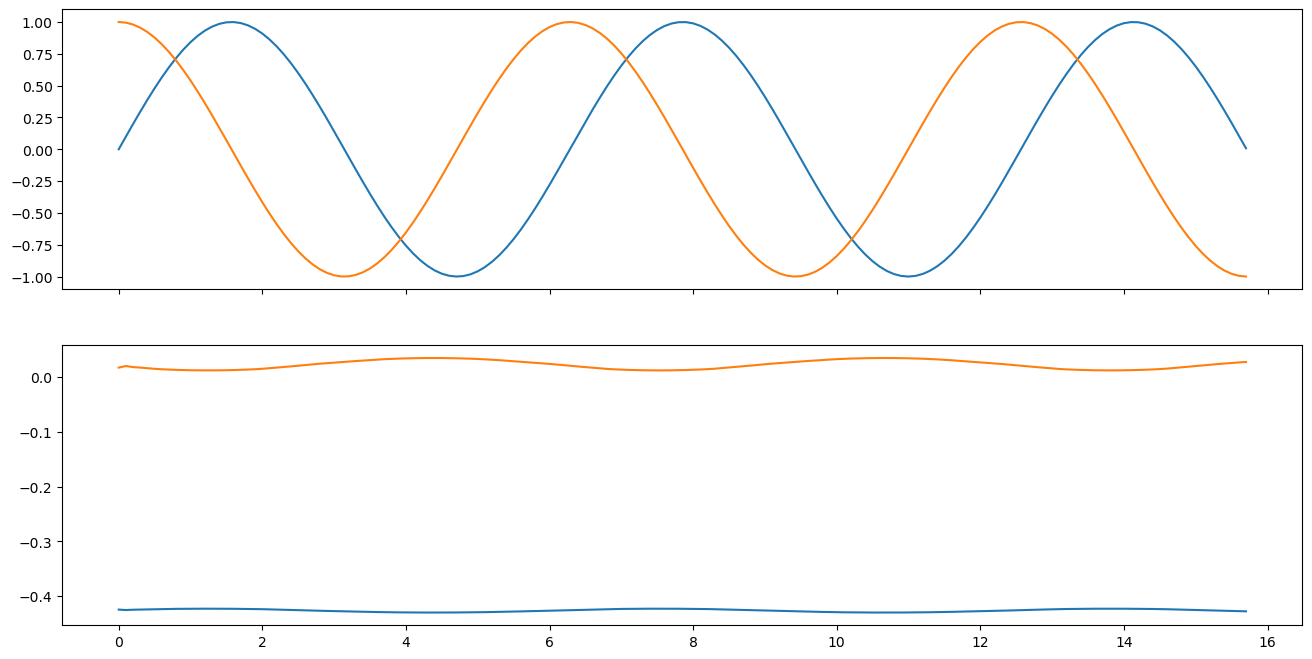

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(16, 8), sharex=True)
axes[0].plot(ts, inputs);
axes[1].plot(ts, output_sequence);